## Deep Learning Course (980)
## Assignment Four 

__Assignment Goals__:

- Implementing Fully Connected AutoEncoders
- Implementing Convolutional AutoEncoders
- Understand Variational Autoncoder intuition


In this assignment, you will be asked to design a Fully Connected and a CNN AutoEncoder. With a simple change in your Fully Connected AutoEncoder, you will become more familiar with Variational AutoEncoder. 

__DataSet:__ In this Assignment, you will use the MNIST handwritten digit database. You can use  (x_train, _), (x_test, _)  = tensorflow.keras.datasets.mnist.load_data() to load the dataset.

1. (30 points) Implement a Fully Connected AutoEncoder in TensorFlow (cf. Chapter 7). Your AutoEncoder should have a bottleneck with two neurons and Mean Squared Error (MSE) as the objective function. In an AutoEncoder, the layer with the least number of neurons is referred to as a bottleneck. Train your model on MNIST. Plot the train and test loss. Randomly select 10 images from the test set, encode them and visualize the decoded images.
     
2. (35 points) Implement a convolutional AutoEncoder (CAE) that uses only the following types of layers: convolution, pooling, upsampling and transpose. You are limited to use MSE. The encoder and decoder should include one or more layers, with the size and number of filters chosen by you. Start with a bottleneck of size 2, train your model on MNIST and plot the train and test loss. Randomly select 10 images from the test set, encode them and visualize the decoded images. Are the reconstructed images readable for humans? If not, try to find a CAE architecture, including a larger bottleneck, that is powerful enough to generate readable images. The bottleneck should be as small as possible for readability, this is part of the grading criteria.

3. (35 points) This question is about using an AutoEncoder to generate similar but not identical hand digits. We use a naive approach: Try to see if a trained decoder can map randomly generated inputs (random numbers) to a recognizable hand-written digit. 
    1. Start with your Fully Connected and trained AutoEncoder from part 1. Try to generate new images by inputting some random numbers  to the decoder (i.e. the bottleneck layer) and report your results. Hint: This is not easy. You probably want to input at least 10 random numbers. 
    2. Now restrict the AutoEncoder hidden bottleneck layer(s) to have a standard multi-variate normal distribution with mean zeroes and the identity matrix as variance (i.e. no correlations). Retrain the Fully Connected AutoEncoder with the normalized bottleneck. Now randomly generate inputs to the bottleneck layer that are drawn from the multi-variate standard normal distribution, and use the random inputs to generate new images. Report your result.
    3. Are the output images different between 1) and 2)? If so, why do you think this difference occurs?

4. (20 points) Optional: change the AutoEncoder which you developed in the last part of section 3 so that it becomes a Variational AutoEncoder (Introduced by Kingma 2014; see Chapter 7.1). Does the VAE produce a different quality of output image?



__Submission Notes__:

Please use Jupyter Notebook. The notebook should include the final code, results, and answers. You should submit your Notebook in .pdf and .ipynb format. (penalty 10 points).
Your AutoEncoders should have only one bottleneck.
 



__Instructions__:

The university policy on academic dishonesty and plagiarism (cheating) will be taken very seriously in this course. Everything submitted should be your writing or coding. You must not let other students copy your work. Spelling and grammar count.



In [190]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Lambda
from keras import backend as K
from keras.callbacks import ModelCheckpoint
import numpy as np
from tensorflow.python.client import device_lib
from matplotlib import pyplot as plt

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

# normalize the data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [191]:
''' Part 1: Implement a Fully Connected AutoEncoder in TensorFlow
'''

# flatten the input image data
input_size = 784
x_train_flatten = x_train.reshape(-1, input_size)
x_test_flatten = x_test.reshape(-1, input_size)

# build the network with a bottleneck of two neurons
autoencoder_fc = Sequential()
autoencoder_fc.add(Dense(512, input_shape=(input_size,), activation='relu'))
autoencoder_fc.add(Dense(2, activation='relu'))
autoencoder_fc.add(Dense(512, input_shape=(input_size,), activation='relu'))
autoencoder_fc.add(Dense(input_size, activation='sigmoid'))

autoencoder_fc.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_40 (Dense)             (None, 2)                 1026      
_________________________________________________________________
dense_41 (Dense)             (None, 512)               1536      
_________________________________________________________________
dense_42 (Dense)             (None, 784)               402192    
Total params: 806,674
Trainable params: 806,674
Non-trainable params: 0
_________________________________________________________________


In [192]:
# train model

print(device_lib.list_local_devices())

autoencoder_fc.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
best_model_checkpoint = ModelCheckpoint(
    './best_model_fc.pth', 
    monitor="val_acc", 
    save_best_only=True, 
    save_weights_only=False
)
autoencoder_fc_history = autoencoder_fc.fit(
    x_train_flatten, 
    x_train_flatten, 
    epochs=50, 
    batch_size=256, 
    shuffle=True, 
    validation_data=(x_test_flatten, x_test_flatten),
    callbacks=[best_model_checkpoint]
)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15136608014551239514
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6700198133
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16821384717117699523
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 5s 77us/step - loss: 0.0709 - acc: 0.0114 - val_loss: 0.0579 - val_acc: 0.0117
Epoch 2/50
60000/60000 [==============================] - 1s 24us/step - loss: 0.0551 - acc: 0.0155 - val_loss: 0.0531 - val_acc: 0.0118
Epoch 3/50
60000/60000 [==============================] - 1s 24us/step - loss: 0.0523 - acc: 0.0108 - val_loss: 0.0511 - val_acc: 0.0074
Epoch 4/50
60000/60000 [==============================] - 1s 23us/step - loss: 0.0504 - acc: 0.0094 - val_loss: 0.0493 - val_acc: 0.0087
Epoch 5/50
60000/60000 [=============

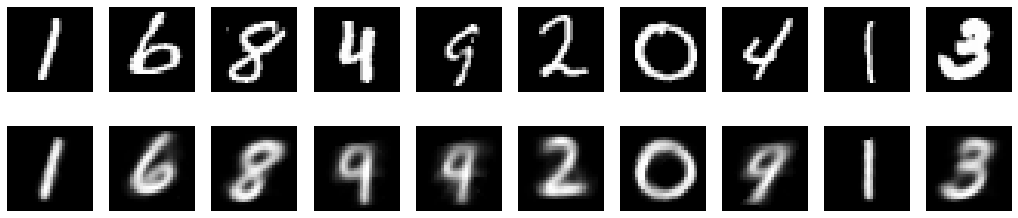

In [193]:
# visualization

img_num = 10
autoencoder_fc_best = load_model('./best_model_fc.pth')
plt.figure(figsize=(18, 4))
plt.gray()
for i in range(img_num):
    # randomly pick an image from test dataset
    chosen_test_img = x_test_flatten[np.random.randint(x_test_flatten.shape[0])]
    img_decoded = autoencoder_fc_best.predict(chosen_test_img.reshape(1, 784))
    ax = plt.subplot(2, img_num, i+1)
    plt.imshow(chosen_test_img.reshape(28, 28))
    ax.axis('off')

    ax = plt.subplot(2, img_num, img_num+i+1)
    plt.imshow(img_decoded.reshape(28, 28))
    ax.axis('off')
plt.show()

In [51]:
''' Part 2: Implement a convolutional AutoEncoder (CAE)
'''

x_train = x_train.reshape((len(x_train), 28, 28, 1))
x_test = x_test.reshape((len(x_test), 28, 28, 1))

# build the network with a bottleneck of two neurons
autoencoder_conv = Sequential()
# encoder network
autoencoder_conv.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=x_train.shape[1:]))
autoencoder_conv.add(MaxPooling2D(pool_size=(2, 2)))
autoencoder_conv.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
autoencoder_conv.add(MaxPooling2D(pool_size=(2, 2)))
autoencoder_conv.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
autoencoder_conv.add(MaxPooling2D(pool_size=(2, 2)))
autoencoder_conv.add(Conv2D(2, (3, 3), activation='relu', padding='same'))
autoencoder_conv.add(MaxPooling2D(pool_size=(2, 2)))
# decoder network
autoencoder_conv.add(Conv2DTranspose(64, (7, 7), activation='relu', padding='valid'))
autoencoder_conv.add(UpSampling2D((2, 2)))
autoencoder_conv.add(Conv2DTranspose(32, (3, 3), activation='relu', padding='same'))
autoencoder_conv.add(UpSampling2D((2, 2)))
autoencoder_conv.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

autoencoder_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_143 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_128 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_144 (Conv2D)          (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_129 (MaxPoolin (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_145 (Conv2D)          (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_130 (MaxPoolin (None, 3, 3, 128)         0         
_________________________________________________________________
conv2d_146 (Conv2D)          (None, 3, 3, 2)           2306      
__________

In [52]:
# train model

print(device_lib.list_local_devices())

autoencoder_conv.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
best_model_checkpoint = ModelCheckpoint(
    './best_model_conv.pth', 
    monitor="val_acc", 
    save_best_only=True, 
    save_weights_only=False
)
autoencoder_conv_history = autoencoder_conv.fit(
    x_train, 
    x_train, 
    epochs=100, 
    batch_size=256, 
    shuffle=True, 
    validation_data=(x_test, x_test),
    callbacks=[best_model_checkpoint]
)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10955589709488089990
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6700198133
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2203474842961559105
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 7s 120us/step - loss: 0.0824 - acc: 0.8029 - val_loss: 0.0576 - val_acc: 0.7937
Epoch 2/100
60000/60000 [==============================] - 4s 70us/step - loss: 0.0555 - acc: 0.7954 - val_loss: 0.0537 - val_acc: 0.7963
Epoch 3/100
60000/60000 [==============================] - 4s 70us/step - loss: 0.0520 - acc: 0.7941 - val_loss: 0.0502 - val_acc: 0.7946
Epoch 4/100
60000/60000 [==============================] - 4s 71us/step - loss: 0.0491 - acc: 0.7948 - val_loss: 0.0474 - val_acc: 0.7945
Epoch 5/100
60000/60000 [========

60000/60000 [==============================] - 4s 72us/step - loss: 0.0379 - acc: 0.8001 - val_loss: 0.0395 - val_acc: 0.7933
Epoch 58/100
60000/60000 [==============================] - 4s 72us/step - loss: 0.0380 - acc: 0.7999 - val_loss: 0.0389 - val_acc: 0.7983
Epoch 59/100
60000/60000 [==============================] - 4s 72us/step - loss: 0.0378 - acc: 0.8001 - val_loss: 0.0391 - val_acc: 0.7976
Epoch 60/100
60000/60000 [==============================] - 4s 72us/step - loss: 0.0378 - acc: 0.8001 - val_loss: 0.0389 - val_acc: 0.7996
Epoch 61/100
60000/60000 [==============================] - 4s 73us/step - loss: 0.0377 - acc: 0.8002 - val_loss: 0.0390 - val_acc: 0.7988
Epoch 62/100
60000/60000 [==============================] - 4s 73us/step - loss: 0.0377 - acc: 0.8002 - val_loss: 0.0389 - val_acc: 0.7995
Epoch 63/100
60000/60000 [==============================] - 4s 72us/step - loss: 0.0376 - acc: 0.8002 - val_loss: 0.0390 - val_acc: 0.7968
Epoch 64/100
60000/60000 [==============

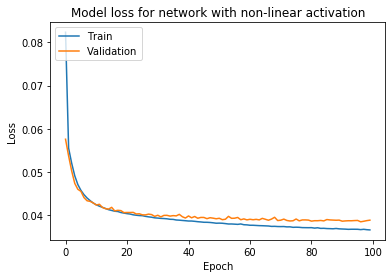

In [106]:
# plot the train and test loss
plt.plot(autoencoder_conv_history.history['loss'])
plt.plot(autoencoder_conv_history.history['val_loss'])
plt.title('Model loss for network with non-linear activation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

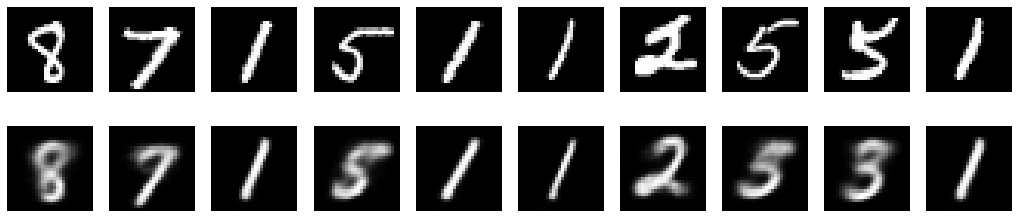

In [56]:
# visualization

img_num = 10
autoencoder_conv_best = load_model('./best_model_conv.pth')
plt.figure(figsize=(18, 4))
plt.gray()
for i in range(img_num):
    # randomly pick an image from test dataset
    chosen_test_img = x_test[np.random.randint(x_test.shape[0])]
    img_decoded = autoencoder_conv_best.predict(chosen_test_img.reshape(1, 28, 28, 1))
    ax = plt.subplot(2, img_num, i+1)
    plt.imshow(chosen_test_img.reshape(28, 28))
    ax.axis('off')

    ax = plt.subplot(2, img_num, img_num+i+1)
    plt.imshow(img_decoded.reshape(28, 28))
    ax.axis('off')
plt.show()

In [99]:
# find a CAE architecture that is powerful enough to generate readable images

# build the network with larger bottleneck
autoencoder_conv_refine = Sequential()
# encoder network
autoencoder_conv_refine.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=x_train.shape[1:]))
autoencoder_conv_refine.add(MaxPooling2D(pool_size=(2, 2)))
autoencoder_conv_refine.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
autoencoder_conv_refine.add(MaxPooling2D(pool_size=(2, 2)))
autoencoder_conv_refine.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
autoencoder_conv_refine.add(MaxPooling2D(pool_size=(2, 2)))
autoencoder_conv_refine.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder_conv_refine.add(MaxPooling2D(pool_size=(2, 2)))
# decoder network
autoencoder_conv_refine.add(Conv2DTranspose(128, (7, 7), activation='relu', padding='valid'))
autoencoder_conv_refine.add(UpSampling2D((2, 2)))
autoencoder_conv_refine.add(Conv2DTranspose(64, (3, 3), activation='relu', padding='same'))
autoencoder_conv_refine.add(UpSampling2D((2, 2)))
autoencoder_conv_refine.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

autoencoder_conv_refine.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_246 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_203 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_247 (Conv2D)          (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_204 (MaxPoolin (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_248 (Conv2D)          (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_205 (MaxPoolin (None, 3, 3, 128)         0         
_________________________________________________________________
conv2d_249 (Conv2D)          (None, 3, 3, 8)           9224      
__________

In [100]:
# train model

print(device_lib.list_local_devices())

autoencoder_conv_refine.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
best_model_checkpoint = ModelCheckpoint(
    './best_model_conv_refine.pth', 
    monitor="val_acc", 
    save_best_only=True, 
    save_weights_only=False
)
autoencoder_conv_refine_history = autoencoder_conv_refine.fit(
    x_train, 
    x_train, 
    epochs=20, 
    batch_size=256, 
    shuffle=True, 
    validation_data=(x_test, x_test),
    callbacks=[best_model_checkpoint]
)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12764486925989334302
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6700198133
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3201361844933033059
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 9s 152us/step - loss: 0.0596 - acc: 0.7995 - val_loss: 0.0331 - val_acc: 0.8050
Epoch 2/20
60000/60000 [==============================] - 6s 107us/step - loss: 0.0275 - acc: 0.8051 - val_loss: 0.0241 - val_acc: 0.8055
Epoch 3/20
60000/60000 [==============================] - 6s 107us/step - loss: 0.0233 - acc: 0.8072 - val_loss: 0.0221 - val_acc: 0.8066
Epoch 4/20
60000/60000 [==============================] - 6s 107us/step - loss: 0.0217 - acc: 0.8080 - val_loss: 0.0215 - val_acc: 0.8083
Epoch 5/20
60000/60000 [==========

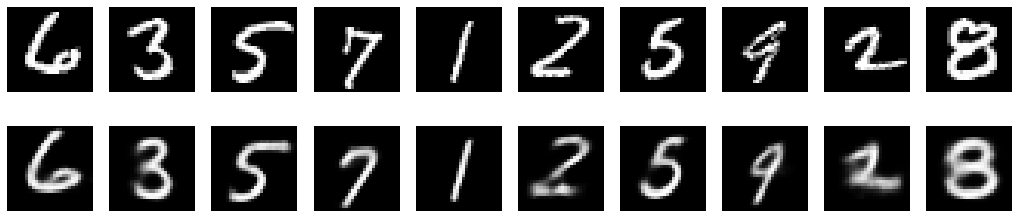

In [101]:
# visualization

img_num = 10
autoencoder_conv_refine_best = load_model('./best_model_conv_refine.pth')
plt.figure(figsize=(18, 4))
plt.gray()
for i in range(img_num):
    # randomly pick an image from test dataset
    chosen_test_img = x_test[np.random.randint(x_test.shape[0])]
    img_decoded = autoencoder_conv_refine_best.predict(chosen_test_img.reshape(1, 28, 28, 1))
    ax = plt.subplot(2, img_num, i+1)
    plt.imshow(chosen_test_img.reshape(28, 28))
    ax.axis('off')

    ax = plt.subplot(2, img_num, img_num+i+1)
    plt.imshow(img_decoded.reshape(28, 28))
    ax.axis('off')
plt.show()

### try to find a CAE architecture, including a larger bottleneck, that is powerful enough to generate readable images.
After enlarge the bottleneck from 2 to 8, the CAE is able to generate readable images as shown above

In [194]:
''' Part 3: using an AutoEncoder to generate similar but not identical hand digits
'''

# Part 3.A:
# load the model trained in part 1
autoencoder_fc_best = load_model('./best_model_fc.pth')
autoencoder_fc_best.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_40 (Dense)             (None, 2)                 1026      
_________________________________________________________________
dense_41 (Dense)             (None, 512)               1536      
_________________________________________________________________
dense_42 (Dense)             (None, 784)               402192    
Total params: 806,674
Trainable params: 806,674
Non-trainable params: 0
_________________________________________________________________


In [195]:
# extract the decoder network from the original model
decoder_fc_layer1 = autoencoder_fc_best.layers[2]
decoder_fc_layer2 = autoencoder_fc_best.layers[3]
decoder_input = Input(shape=(2,))
decoder_fc = Model(decoder_input, decoder_fc_layer2(decoder_fc_layer1(decoder_input)))
decoder_fc.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
dense_41 (Dense)             (None, 512)               1536      
_________________________________________________________________
dense_42 (Dense)             (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


[[41.24259489 74.10231016]
 [50.60932565 28.17127169]
 [54.25687715  6.43226866]
 [88.42651825 82.78604145]
 [33.72183453 95.34157317]
 [38.49827966 69.10400883]
 [46.05383525 19.01590636]
 [31.40786591 68.2574428 ]
 [46.41279965 50.0538565 ]
 [30.48320335 83.99890743]]


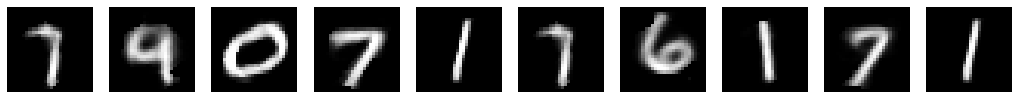

In [199]:
img_num = 10
plt.figure(figsize=(18, 4))
plt.gray()

# randomly generate some numbers as the input of decoder
generated_input = (np.random.rand(img_num, 2, )) * 100
print(generated_input)
generated_imgs = decoder_fc.predict(generated_input)

for i in range(img_num):
    img_decoded = generated_imgs[i]
    ax = plt.subplot(1, img_num, i+1)
    plt.imshow(img_decoded.reshape(28, 28))
    ax.axis('off')
plt.show()

In [200]:
# Part 3.B: 
# restrict the AutoEncoder hidden bottleneck layer(s)
# to have a standard multi-variate normal distribution
# with mean zeroes and the identity matrix as variance
def normalize_bottleneck(args):
    norm_mean, norm_var = args
    eps = K.random_normal(shape=(K.shape(norm_mean)[0], K.int_shape(norm_mean)[1]))
    norm = norm_mean + K.exp(0.5 * norm_var) * eps
    return norm

# flatten the input image data
input_size = 784
x_train_flatten = x_train.reshape(-1, input_size)
x_test_flatten = x_test.reshape(-1, input_size)

# construct the encoder part
autoencoder_fc_norm_input = Input(shape=(input_size, ))
intermediate_output1 = Dense(512, activation='relu')(autoencoder_fc_norm_input)
norm_mean = Dense(2)(intermediate_output1)
norm_var = Dense(2)(intermediate_output1)
encoder_output = Lambda(normalize_bottleneck, output_shape=(2, ))([norm_mean, norm_var])
# construct the decoder part
intermediate_output2 = Dense(512, activation='relu')(encoder_output)
decoder_output = Dense(input_size, activation='sigmoid')(intermediate_output2)

autoencoder_fc_norm = Model(autoencoder_fc_norm_input, decoder_output)
autoencoder_fc_norm.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 784)          0                                            
__________________________________________________________________________________________________
dense_43 (Dense)                (None, 512)          401920      input_19[0][0]                   
__________________________________________________________________________________________________
dense_44 (Dense)                (None, 2)            1026        dense_43[0][0]                   
__________________________________________________________________________________________________
dense_45 (Dense)                (None, 2)            1026        dense_43[0][0]                   
__________________________________________________________________________________________________
lambda_8 (

In [201]:
# train model

print(device_lib.list_local_devices())

autoencoder_fc_norm.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
best_model_checkpoint = ModelCheckpoint(
    './best_model_fc_norm.pth', 
    monitor="val_acc", 
    save_best_only=True, 
    save_weights_only=False
)
autoencoder_fc_history = autoencoder_fc_norm.fit(
    x_train_flatten, 
    x_train_flatten, 
    epochs=50, 
    batch_size=256, 
    shuffle=True, 
    validation_data=(x_test_flatten, x_test_flatten),
    callbacks=[best_model_checkpoint]
)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5998046289788614467
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6700198133
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14375085748194495944
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 5s 82us/step - loss: 0.0705 - acc: 0.0129 - val_loss: 0.0562 - val_acc: 0.0099
Epoch 2/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.0543 - acc: 0.0148 - val_loss: 0.0520 - val_acc: 0.0128
Epoch 3/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.0513 - acc: 0.0146 - val_loss: 0.0501 - val_acc: 0.0126
Epoch 4/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.0496 - acc: 0.0111 - val_loss: 0.0489 - val_acc: 0.0084
Epoch 5/50
60000/60000 [==============

In [202]:
# load the best model with normalized bottleneck
autoencoder_fc_norm_best = load_model('./best_model_fc_norm.pth')

# extract the decoder network from the original model
decoder_fc_norm_layer1 = autoencoder_fc_norm_best.layers[5]
decoder_fc_norm_layer2 = autoencoder_fc_norm_best.layers[6]
decoder_norm_input = Input(shape=(2,))
decoder_fc_norm = Model(decoder_norm_input, decoder_fc_norm_layer2(decoder_fc_norm_layer1(decoder_norm_input)))
decoder_fc_norm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
dense_46 (Dense)             (None, 512)               1536      
_________________________________________________________________
dense_47 (Dense)             (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


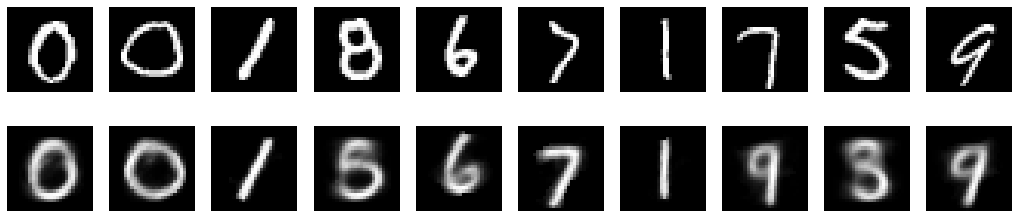

In [203]:
# visualization

img_num = 10
autoencoder_fc_best_norm = load_model('./best_model_fc_norm.pth')
plt.figure(figsize=(18, 4))
plt.gray()
for i in range(img_num):
    # randomly pick an image from test dataset
    chosen_test_img = x_test_flatten[np.random.randint(x_test_flatten.shape[0])]
    img_decoded = autoencoder_fc_best_norm.predict(chosen_test_img.reshape(1, 784))
    ax = plt.subplot(2, img_num, i+1)
    plt.imshow(chosen_test_img.reshape(28, 28))
    ax.axis('off')

    ax = plt.subplot(2, img_num, img_num+i+1)
    plt.imshow(img_decoded.reshape(28, 28))
    ax.axis('off')
plt.show()

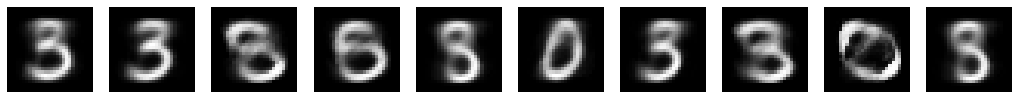

In [218]:
img_num = 10
plt.figure(figsize=(18, 4))
plt.gray()

generated_mean = (np.random.rand(img_num, 2, )) * 3
generated_var = (np.random.rand(img_num, 2, )) * 3
eps = np.random.normal(loc=0.0, scale=1.0, size=(10, 2))
generated_norm = generated_mean + np.exp(0.5 * generated_var) * eps
predicted_imgs = decoder_fc_norm.predict(generated_norm)

for i in range(img_num):
    img_decoded = predicted_imgs[i]
    ax = plt.subplot(1, img_num, i+1)
    plt.imshow(img_decoded.reshape(28, 28))
    ax.axis('off')
plt.show()